In [293]:
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as plt
import multiprocessing
import subprocess as spb
import glob, os
import csv
import time
# Linear Regration
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Neaural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
size_z,size_y,size_x=60,60,48

In [297]:
# Class to read out polarization data from *.coord files
class DATA():

    def __init__(self, path):
        self.size=48
        self.main_path=path
        self.full_data=[]

    def read_coord(self,d):
        d=d.split(' ')
        d=filter(None, d)
        d=[float(i) for i in d]
        return float(d[3]), float(d[4]), float(d[5])

    def gep_t(self,coord):
        data=open('{}.coord'.format(coord),'r').readlines()
        p=list(map(self.read_coord, data))
        p1=np.array(p)[:,0]
        p2=np.array(p)[:,1]
        p3=np.array(p)[:,2]
        return p1,p2,p3

    def collecp_tt(self, pt_all, coord):
        P=self.gep_t(coord)
        pt_all.append([coord,P])
        return pt_all

    def multithread(self, coords):
        with multiprocessing.Manager() as manager:
            pt_all=manager.list()
            processes=[]
            for coord in coords:
                p = multiprocessing.Process(target=self.collecp_tt, args=(pt_all, coord))
                p.start()
                processes.append(p)
            for p in processes:
                p.join()
            i=0
            for pt in pt_all:
                self.full_data.append(pt)

    def run(self):
        os.chdir(self.main_path)
        coords= [int(file.split('.')[0]) for file in glob.glob("*.coord")]
        coords.sort()
        split=6
        for coords_teil in [coords[split*i:split*(i+1)] for i in range(int(len(coords)/split))]\
        +[coords[int(len(coords)/split)*split:int(len(coords)/split)*split+len(coords)%split]]:
            self.multithread(coords_teil)
        return self.full_data

def p_t(d,t):
    px=np.array(d[t][1][0])
    py=np.array(d[t][1][1])
    pz=np.array(d[t][1][2])
    t=d[t][0]
    return t,px,py,pz

In [ ]:
# collect and store polarization data
start_t=time.time()
path="/home/rub/Desktop/NN_scratch/feram/coords/"
#os.chdir('{}'.format(path))
R=DATA(path)
data=R.run()
data.sort()
tp=[p_t(data,i) for i in range(len(data))]
print(time.time()-start_t)

In [147]:
# write csv file which containes information about neighbors and polarization change
def neighbor_data_csv(pz,pz2,file_name):
    header = ['cell_000','cell_001','cell_100', 'cell_011', 'cell_111', 'cell_200', 'cell_201', 'delta_cell']
    with open(file_name, 'w', newline='') as f:
        writer =  writer = csv.writer(f)
        writer.writerow(header)
    for _ in range(40000):
        z,y,x=np.random.randint(size_z),np.random.randint(size_y),np.random.randint(size_x)
        cell_000=pz[z%size_z,y%size_y,x%size_x]
        cell_001=(pz[z%size_z,y%size_y,(x+1)%size_x]+pz[z%size_z,y%size_y,(x-1)%size_x])/2.0
        cell_010=(pz[z%size_z,(y+1)%size_y,x%size_x]+pz[z%size_z,(y-1)%size_y,x%size_x])/2.0
        cell_100=(pz[(z+1)%size_z,y%size_y,x%size_x]+pz[(z-1)%size_z,y%size_y,x%size_x])/2.0
        cell_011=(pz[z%size_z,(y+1)%size_y,(x+1)%size_x]+\
                 pz[z%size_z,(y+1)%size_y,(x-1)%size_x]+\
                 pz[z%size_z,(y-1)%size_y,(x+1)%size_x]+\
                 pz[z%size_z,(y-1)%size_y,(x-1)%size_x])/4.0
        cell_101=(pz[(z+1)%size_z,y%size_y,(x+1)%size_x]+\
                 pz[(z+1)%size_z,y%size_y,(x-1)%size_x]+\
                 pz[(z-1)%size_z,y%size_y,(x+1)%size_x]+\
                 pz[(z-1)%size_z,y%size_y,(x-1)%size_x])/4.0
        cell_110=(pz[(z+1)%size_z,(y+1)%size_y,x%size_x]+\
                 pz[(z+1)%size_z,(y-1)%size_y,x%size_x]+\
                 pz[(z-1)%size_z,(y+1)%size_y,x%size_x]+\
                 pz[(z-1)%size_z,(y-1)%size_y,x%size_x])/4.0
        cell_111=(pz[(z+1)%size_z,(y+1)%size_y,x%size_x]+\
                 pz[(z+1)%size_z,(y+1)%size_y,(x-1)%size_x]+\
                 pz[(z+1)%size_z,(y-1)%size_y,(x+1)%size_x]+\
                 pz[(z+1)%size_z,(y-1)%size_y,(x-1)%size_x]+\
                 pz[(z-1)%size_z,(y+1)%size_y,(x+1)%size_x]+\
                 pz[(z-1)%size_z,(y+1)%size_y,(x-1)%size_x]+\
                 pz[(z-1)%size_z,(y-1)%size_y,(x+1)%size_x]+\
                 pz[(z-1)%size_z,(y-1)%size_y,(x-1)%size_x])/8.0
        cell_200=(pz[(z+2)%size_z,y%size_y,x%size_x]+pz[(z-2)%size_z,y%size_y,x%size_x])/2.0
        cell_201=(pz[(z+2)%size_z,y%size_y,(x+1)%size_x]+\
                 pz[(z+2)%size_z,y%size_y,(x-1)%size_x]+\
                 pz[(z+2)%size_z,(y+1)%size_y,x%size_x]+\
                 pz[(z+2)%size_z,(y-1)%size_y,x%size_x]+\
                 pz[(z-2)%size_z,y%size_y,(x+1)%size_x]+\
                 pz[(z-2)%size_z,y%size_y,(x-1)%size_x]+\
                 pz[(z-2)%size_z,(y+1)%size_y,x%size_x]+\
                 pz[(z-2)%size_z,(y-1)%size_y,x%size_x])/8.0
        delta_cell=(pz2[z%size_z,y%size_y,x%size_x]-pz[z%size_z,y%size_y,x%size_x])*2
        with open(file_name, 'a', newline='') as f:
            writer =  writer = csv.writer(f)
            writer.writerow([cell_000,(cell_001+cell_010)/2.0,cell_100,(cell_011+cell_101+cell_110)/3.0,cell_111, cell_200, cell_201, delta_cell])

In [212]:
# create training data
t,px,py,pz=tp[0]
pz = pz.reshape(size_z,size_y,size_x)
t2,px2,py2,pz2=tp[1]
pz2 = pz2.reshape(size_z,size_y,size_x)
neighbor_data_csv(pz,pz2,'pz_4nn.csv')

In [ ]:
data=pd.read_csv("pz_4nn.csv")
y=data["delta_cell"]
X=data.drop(["delta_cell"], axis=1)

In [213]:
# create testing data
t,px,py,pz=tp[2]
pz = pz.reshape(size_z,size_y,size_x)
t2,px2,py2,pz2=tp[3]
pz2 = pz2.reshape(size_z,size_y,size_x)
neighbor_data_csv(pz,pz2,'pz_4nn_test.csv')

In [ ]:
data_test=pd.read_csv("pz_4nn_test.csv")
y_test=data_test["delta_cell"]
X_test=data_test.drop(["delta_cell"], axis=1)

# train with Linear Regration

In [214]:
df=pd.DataFrame(data, columns=header)
clf = LinearRegression().fit(X, y)
print("table of correlation of different cells with delta_cell")
abs(df.corr()["delta_cell"]).sort_values(ascending=True)

cell_200      0.008787
cell_001      0.061197
cell_111      0.086031
cell_201      0.092741
cell_011      0.100115
cell_100      0.350388
cell_000      0.731486
delta_cell    1.000000
Name: delta_cell, dtype: float64

# test of Linear Regration

In [216]:
df=pd.DataFrame(data_test, columns=header)
abs(df.corr()["delta_cell"]).sort_values(ascending=True)

cell_200      0.008787
cell_001      0.061197
cell_111      0.086031
cell_201      0.092741
cell_011      0.100115
cell_100      0.350388
cell_000      0.731486
delta_cell    1.000000
Name: delta_cell, dtype: float64

In [217]:
predict=clf.predict(X_test)
score = clf.score(X_test, y_test)

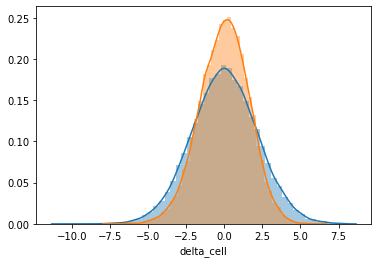

In [77]:
sns.distplot(y_test)
sns.distplot(predict)

(-12, 12)

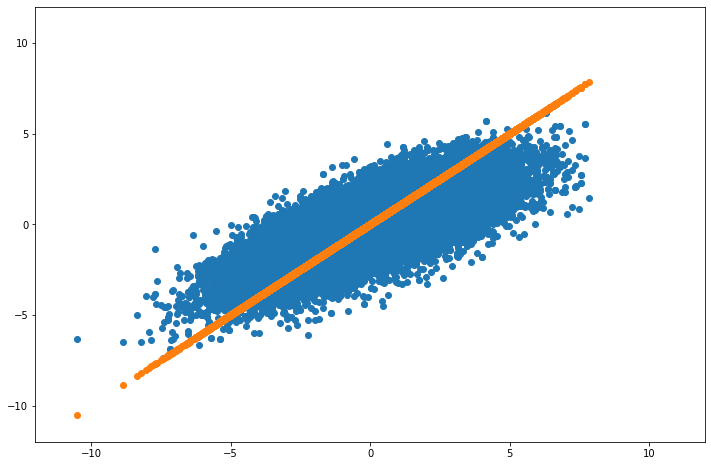

In [78]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,predict)
plt.scatter(y_test,y_test)
plt.xlim(-12,12)
plt.ylim(-12,12)

# Train of Dense NN

In [285]:
model = Sequential()

model.add(Dense(7,activation='linear'))
model.add(Dense(10,activation='linear'))
model.add(Dense(10,activation='linear'))
model.add(Dense(10,activation='linear'))
model.add(Dense(1))

model.compile(loss="binary_crossentropy", optimizer = "adam")

model.fit(x=X, y=y, epochs=5)

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1250/1250 [==============================] - 2s 1ms/step - loss: -12.6366
Epoch 2/5
1250/1250 [==============================] - 1s 1ms/step - loss: -13.1122
Epoch 3/5
1250/1250 [==============================] - 1s 1ms/step - loss: -12.9747
Epoch 4/5
1250/1250 [==============================] - 1s 1ms/step - loss: -13.1959
Epoch 5/5
1250/1250 [==============================] - 1s 1ms/step - loss: -13.3350


# test of Dense NN

In [286]:
predict = model.predict(X_test).reshape(1,-1)[0]

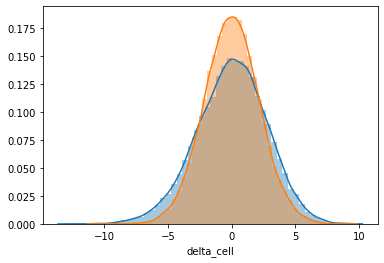

In [287]:
predict = model.predict(X_test).reshape(1,-1)[0]
sns.distplot(predict-np.mean(predict))
sns.distplot(y_test)

(-12, 12)

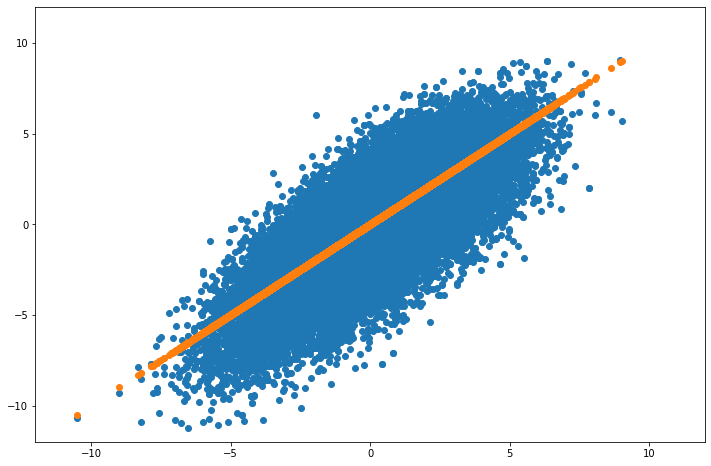

In [288]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,predict)
plt.scatter(y_test,y_test)
plt.xlim(-12,12)
plt.ylim(-12,12)

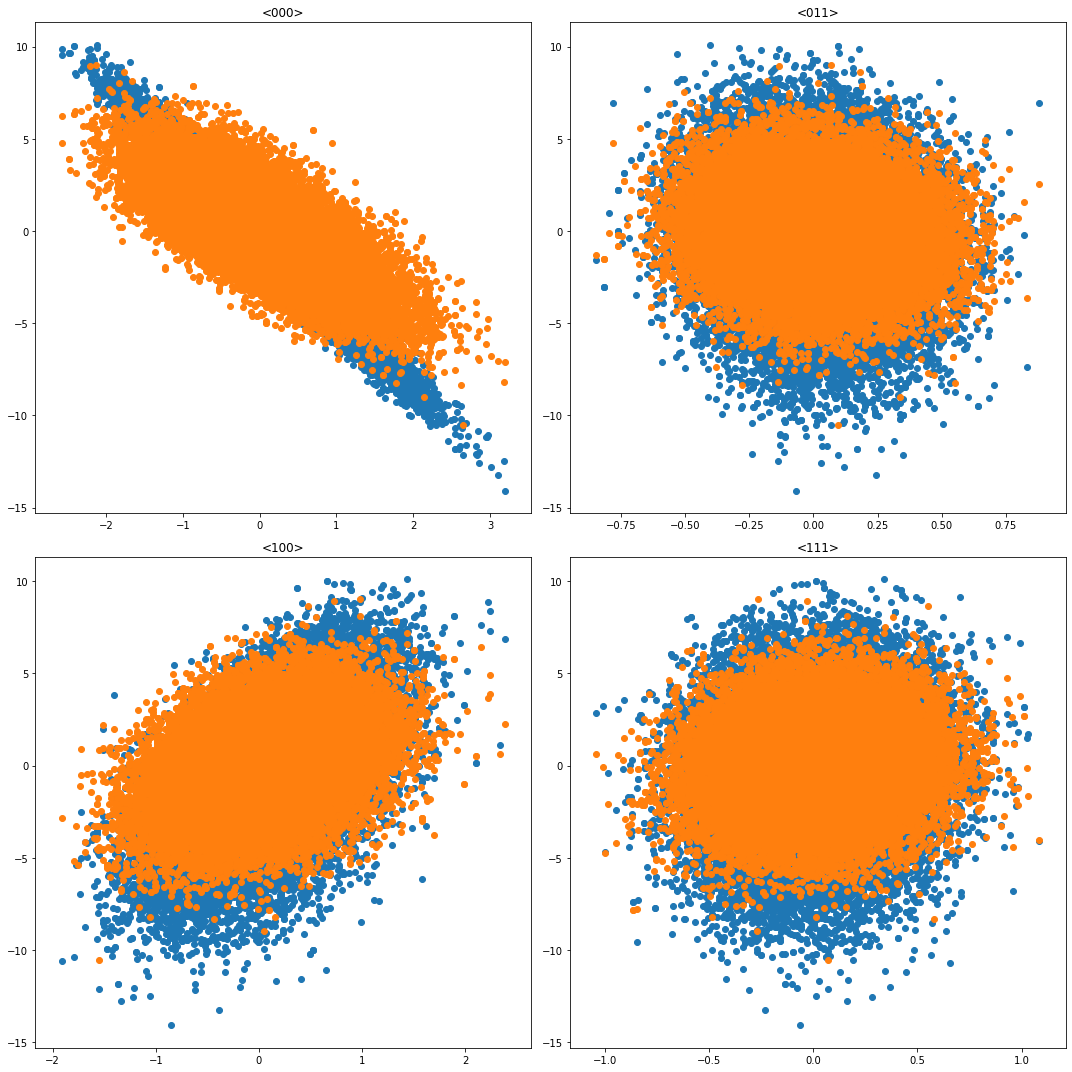

In [227]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 15), tight_layout=True)
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[0, 0])
plt.title('<000>')
ax.scatter(X_test["cell_000"],predict)
ax.scatter(X_test["cell_000"],y_test)
ax = fig.add_subplot(gs[1, 0])
plt.title('<100>')
ax.scatter(X_test["cell_100"],predict)
ax.scatter(X_test["cell_100"],y_test)
ax = fig.add_subplot(gs[0, 1])
plt.title('<011>')
ax.scatter(X_test["cell_011"],predict)
ax.scatter(X_test["cell_011"],y_test)
ax = fig.add_subplot(gs[1, 1])
plt.title('<111>')
ax.scatter(X_test["cell_201"],predict)
ax.scatter(X_test["cell_201"],y_test)

In [42]:
# further improvement

In [110]:
def neighbor_data_csv(pz,pz2,px,py,file_name):
    header = ['cellz_000', 'celly_000', 'cellx_000', 'cellz_100', 'celly_010', 'cellx_001', 'delta_cell']
    with open(file_name, 'w', newline='') as f:
        writer =  writer = csv.writer(f)
        writer.writerow(header)
    for _ in range(40000):
        z,y,x=np.random.randint(size_z),np.random.randint(size_y),np.random.randint(size_x)
        cellz_000=pz[z%size_z,y%size_y,x%size_x]
        celly_000=py[z%size_z,y%size_y,x%size_x]
        cellx_000=px[z%size_z,y%size_y,x%size_x]
        cellz_100=(pz[(z+1)%size_z,y%size_y,x%size_x]+pz[(z-1)%size_z,y%size_y,x%size_x])/2.0
        celly_010=(pz[z%size_z,(y+1)%size_y,x%size_x]+pz[z%size_z,(y-1)%size_y,x%size_x])/2.0
        cellx_001=(pz[z%size_z,y%size_y,(x+1)%size_x]+pz[z%size_z,y%size_y,(x-1)%size_x])/2.0
        delta_cell=(pz2[z%size_z,y%size_y,x%size_x]-pz[z%size_z,y%size_y,x%size_x])*2
        with open(file_name, 'a', newline='') as f:
            writer =  writer = csv.writer(f)
            writer.writerow([cellz_000, celly_000, cellx_000, cellz_100, celly_010, cellx_001, delta_cell])

In [133]:
t,px,py,pz=tp[0]
pz = pz.reshape(size_z,size_y,size_x)
py = py.reshape(size_z,size_y,size_x)
px = px.reshape(size_z,size_y,size_x)
t2,px2,py2,pz2=tp[1]
pz2 = pz2.reshape(size_z,size_y,size_x)
py2 = py2.reshape(size_z,size_y,size_x)
px2 = px2.reshape(size_z,size_y,size_x)
neighbor_data_csv(pz,pz2,px,py,'pz_py_px_2nn.csv')

In [117]:
t,px,py,pz=tp[2]
pz = pz.reshape(size_z,size_y,size_x)
py = py.reshape(size_z,size_y,size_x)
px = px.reshape(size_z,size_y,size_x)
t2,px2,py2,pz2=tp[3]
pz2 = pz2.reshape(size_z,size_y,size_x)
py2 = py2.reshape(size_z,size_y,size_x)
px2 = px2.reshape(size_z,size_y,size_x)
neighbor_data_csv(pz,pz2,px,py,'pz_py_px_2nn_test.csv')

In [134]:
data=pd.read_csv("pz_py_px_2nn.csv")
df=pd.DataFrame(data, columns=['cellz_000', 'celly_000', 'cellx_000', 'cellz_100', 'celly_010', 'cellx_001', 'delta_cell'])
abs(df.corr()["delta_cell"]).sort_values(ascending=True)

celly_000     0.001413
cellx_000     0.002026
cellx_001     0.039967
celly_010     0.043326
cellz_100     0.352798
cellz_000     0.730734
delta_cell    1.000000
Name: delta_cell, dtype: float64

In [135]:
y=data["delta_cell"]
X=data.drop(["delta_cell"], axis=1)

In [136]:
model = Sequential()

model.add(Dense(6,activation='linear'))
model.add(Dense(10,activation='linear'))
model.add(Dense(10,activation='linear'))
model.add(Dense(1))

model.compile(loss="binary_crossentropy", optimizer = "adam")

In [144]:
model.fit(x=X, y=y, epochs=15)

Epoch 1/15
1250/1250 [==============================] - 1s 1ms/step - loss: -12.8136
Epoch 2/15
1250/1250 [==============================] - 1s 1ms/step - loss: -12.7187
Epoch 3/15
1250/1250 [==============================] - 1s 1ms/step - loss: -13.0532
Epoch 4/15
1250/1250 [==============================] - 2s 1ms/step - loss: -12.8793
Epoch 5/15
1250/1250 [==============================] - 1s 1ms/step - loss: -12.4786
Epoch 6/15
1250/1250 [==============================] - 1s 1ms/step - loss: -12.8206
Epoch 7/15
1250/1250 [==============================] - 1s 1ms/step - loss: -12.8808
Epoch 8/15
1250/1250 [==============================] - 1s 1ms/step - loss: -12.9009
Epoch 9/15
1250/1250 [==============================] - 1s 1ms/step - loss: -12.9379
Epoch 10/15
1250/1250 [==============================] - 1s 1ms/step - loss: -12.8152
Epoch 11/15
1250/1250 [==============================] - 2s 1ms/step - loss: -12.6648
Epoch 12/15
1250/1250 [==============================] - 2s 1ms

In [138]:
data_test=pd.read_csv("pz_py_px_2nn_test.csv")
df=pd.DataFrame(data_test, columns=['cellz_000', 'celly_000', 'cellx_000', 'cellz_100', 'celly_010', 'cellx_001', 'delta_cell'])

In [139]:
y_test=data_test["delta_cell"]
X_test=data_test.drop(["delta_cell"], axis=1)

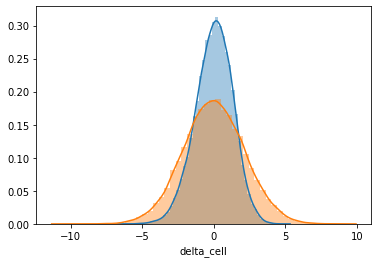

In [140]:
predict = model.predict(X_test).reshape(1,-1)[0]
sns.distplot(predict-np.mean(predict))
sns.distplot(y_test)

(-12, 12)

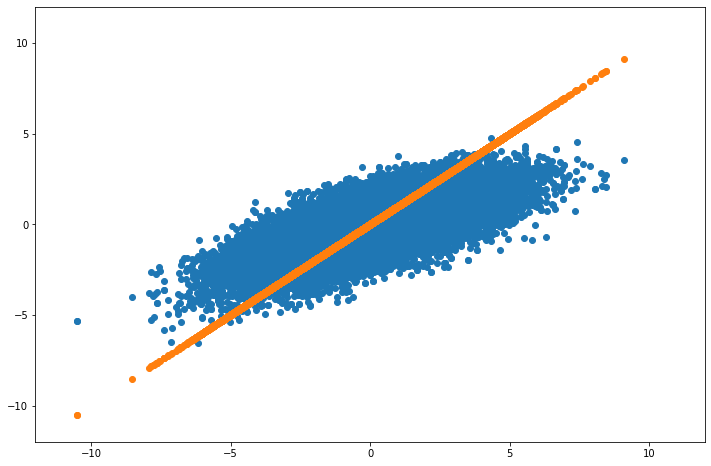

In [141]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,predict)
plt.scatter(y_test,y_test)
plt.xlim(-12,12)
plt.ylim(-12,12)

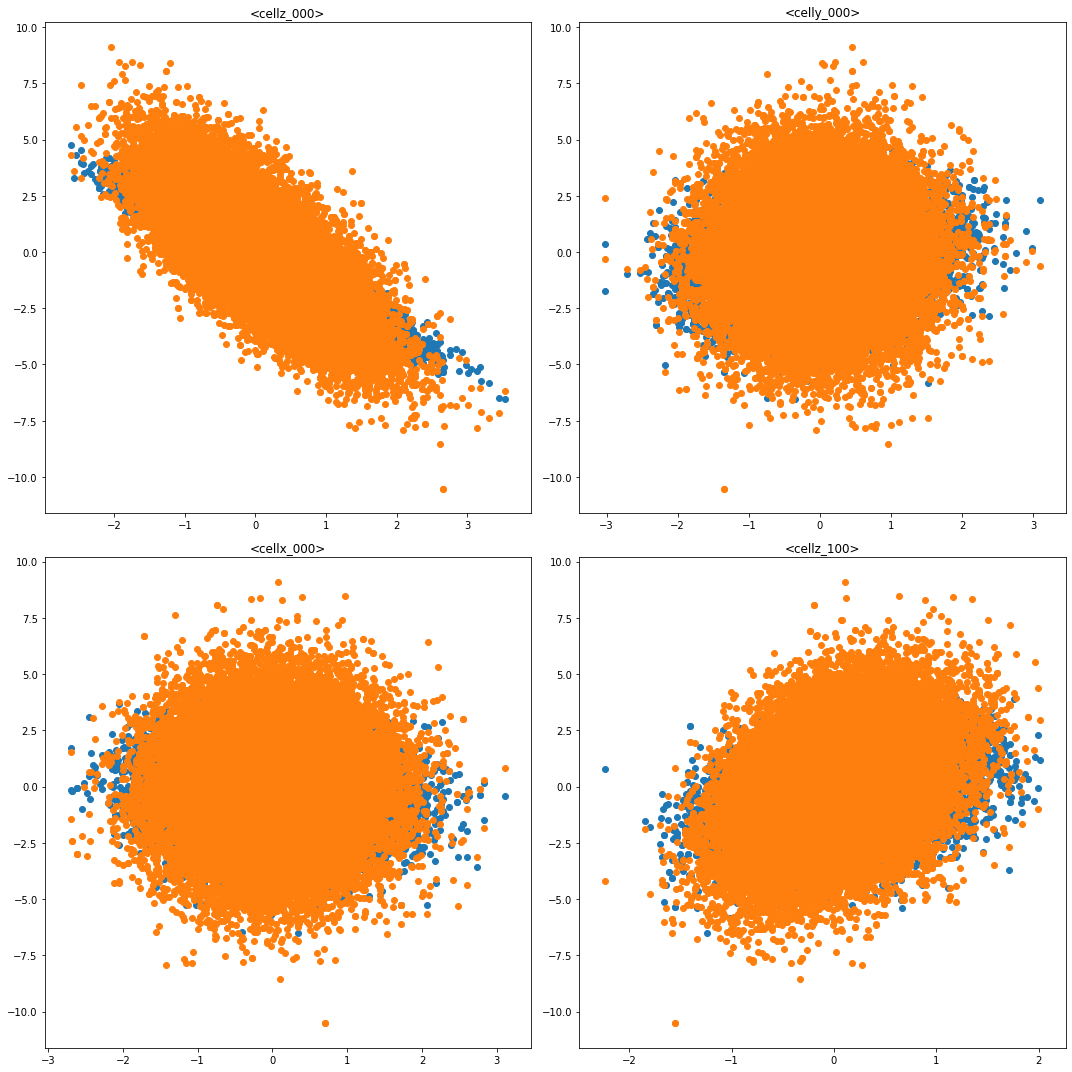

In [143]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 15), tight_layout=True)
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[0, 0])
plt.title('<cellz_000>')
ax.scatter(X_test["cellz_000"],predict)
ax.scatter(X_test["cellz_000"],y_test)
ax = fig.add_subplot(gs[1, 0])
plt.title('<cellx_000>')
ax.scatter(X_test["cellx_000"],predict)
ax.scatter(X_test["cellx_000"],y_test)
ax = fig.add_subplot(gs[0, 1])
plt.title('<celly_000>')
ax.scatter(X_test["celly_000"],predict)
ax.scatter(X_test["celly_000"],y_test)
ax = fig.add_subplot(gs[1, 1])
plt.title('<cellz_100>')
ax.scatter(X_test["cellz_100"],predict)
ax.scatter(X_test["cellz_100"],y_test)

In [257]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.
